In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [3]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [8]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = XY.loc[XY['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.2)
trainXY.shape

(14629, 20)

In [9]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [11]:
trainXY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
70985,7621.38,3270.898620,0.711,candu37,phwr,0.006121,2.3170,2.2850,0.001314,0.61860,1.7250,0.074430,0.002673,5.967,0.89770,0.085570,0.009831,0.009979,0.37550,0.21730
64593,2344.12,4670.129389,0.711,candu37,phwr,0.000974,0.7178,0.7106,0.000031,0.20190,0.4896,0.018480,0.000191,2.303,0.09842,0.002435,0.000087,0.010960,0.10550,0.05306
57629,5778.67,61.232556,0.711,candu19,phwr,0.003613,1.7640,1.7420,0.013220,0.47500,1.6060,0.051250,0.003077,4.679,0.46100,0.044660,0.002231,0.010910,0.27820,0.16000
43551,1604.81,4903.026823,3.630,agr,agr,0.000871,0.4858,0.4849,0.000025,0.21820,0.3285,0.013580,0.000126,2.712,0.14250,0.006141,0.000205,0.010650,0.07055,0.03019
59790,8282.21,1601.145687,0.711,candu19,phwr,0.006649,2.5200,2.4830,0.006795,0.66070,2.0810,0.080780,0.004491,6.106,0.89530,0.100600,0.009612,0.010600,0.40660,0.23950
426,946.26,4288.266818,3.100,ce14x14,pwr,0.000358,0.2850,0.2849,0.000012,0.06958,0.2010,0.007911,0.000053,2.252,0.04941,0.001546,0.000023,0.014230,0.03359,0.01605
4311,4708.95,2815.125153,3.100,ce14x14,pwr,0.004111,1.4010,1.3950,0.001628,0.33480,1.0940,0.051540,0.001889,8.697,0.86270,0.150400,0.009382,0.017160,0.22910,0.11610
63202,1379.90,662.422958,0.711,candu37,phwr,0.000478,0.4231,0.4191,0.000388,0.12080,0.3717,0.010510,0.000160,1.414,0.03426,0.000845,0.000010,0.011040,0.05738,0.02698
57817,5778.67,1862.303821,0.711,candu19,phwr,0.003625,1.7640,1.7420,0.002527,0.47500,1.4340,0.051250,0.002068,4.678,0.46080,0.035160,0.002231,0.010910,0.27820,0.16000
24122,7759.88,698.121617,2.990,vver1000,pwr,0.009646,2.2910,2.2700,0.030830,0.55390,2.0550,0.101500,0.008112,12.580,1.89200,0.678200,0.055220,0.018050,0.40030,0.20560


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [12]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 43552
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152


In [13]:
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
43552,agr,4943.330778,3.63,1604.81,agr


In [14]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [15]:
row_unc = 0.14
test_unc = 0.14
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc), axis=1)
#############################################################################
# pandas converts each row to a series, so using .iloc[0] on the single-row #
# dataframe that is test_sample allows the function to work properly        #
#############################################################################

In [16]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [17]:
trainXY.head(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,LogLikelihood,LLUncertainty
30144,5818.52,797.916619,3.740,vver1000,pwr,0.006421,1.7180,1.7110,0.017160,0.43670,...,0.004799,11.630,1.36000,0.406100,0.023810,0.01865,0.29150,0.14760,-2172.036082,22.976952
68539,5758.47,3785.258289,0.711,candu37,phwr,0.003825,1.7550,1.7340,0.000459,0.47700,...,0.001372,4.882,0.54370,0.036840,0.003218,0.01077,0.27890,0.15830,-215.128161,21.090583
289,946.26,2731.696232,3.100,ce14x14,pwr,0.000358,0.2850,0.2849,0.000048,0.06958,...,0.000074,2.253,0.04943,0.001901,0.000023,0.01423,0.03359,0.01605,7.171480,507.152446
40723,7636.02,1288.830778,3.090,agr,agr,0.010950,2.2820,2.2620,0.013460,1.01500,...,0.005540,7.528,1.68700,0.479900,0.054830,0.01107,0.39030,0.20210,-891.206634,23.588197
23348,6762.83,2860.944376,2.990,vver1000,pwr,0.007665,2.0020,1.9870,0.003216,0.48250,...,0.003806,11.630,1.57200,0.372200,0.034570,0.01804,0.34280,0.17680,-2228.259602,23.327125
18487,1829.59,4442.878840,2.990,vver1000,pwr,0.000933,0.5489,0.5480,0.000048,0.13110,...,0.000189,4.355,0.17930,0.009888,0.000289,0.01572,0.07690,0.03624,-53.671398,12.536359
69043,5832.51,3814.494632,0.711,candu37,phwr,0.003906,1.7770,1.7560,0.000459,0.48280,...,0.001397,4.930,0.55640,0.038040,0.003386,0.01076,0.28270,0.16070,-224.428803,21.171912
64998,2831.03,3425.453488,0.711,candu37,phwr,0.001276,0.8663,0.8574,0.000145,0.24230,...,0.000365,2.723,0.14250,0.005013,0.000187,0.01028,0.13070,0.06730,5.851717,12.716286
8021,9123.05,30.167051,3.100,ce14x14,pwr,0.012220,2.6880,2.6520,0.079310,0.64830,...,0.013390,12.920,2.18600,1.027000,0.092790,0.01873,0.48180,0.24250,-3152.579931,24.308462
56021,4594.77,3982.017014,0.711,candu19,phwr,0.002516,1.4050,1.3880,0.000224,0.38310,...,0.000822,3.883,0.29890,0.013700,0.000881,0.01035,0.21900,0.12260,-75.255175,18.583641


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [18]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: 12.55223552635484 +/- 320.5208625965149


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
25563,pwr,81.549126,3.74,937.48,vver1000


#### AGR

In [19]:
max_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].max()
idx_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].idxmax()
unc_agr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_agr])
print(f'Max Log Likelihood for AGRs: {max_agr} +/- {unc_agr}')
trainXY.loc[trainXY.index == idx_agr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for AGRs: 15.707598493159649 +/- 0.3742317995278192


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
43551,agr,4903.026823,3.63,1604.81,agr


#### PHWR

In [20]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: 8.257512155350222 +/- 55.63853006066419


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
64633,phwr,5861.072275,0.711,2344.12,candu37


## LL wrt Burnup and Cool Time

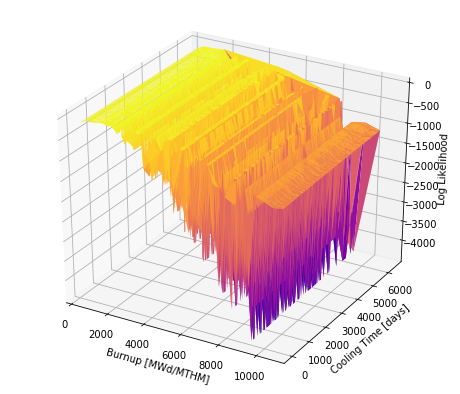

In [21]:
x = trainXY['Burnup']
y = trainXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = trainXY['LogLikelihood']

fig = plt.figure(figsize=(8, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap=plt.cm.plasma)
#ax.scatter(x, y, z)
ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [22]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [23]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
X.shape

(14629, 16)

In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 27681.316033
         Iterations: 3281
         Function evaluations: 4470
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -4.0495e+08
Model:                        NormMod   AIC:                         8.099e+08
Method:            Maximum Likelihood   BIC:                         8.099e+08
Date:                Mon, 26 Aug 2019                                         
Time:                        12:40:39                                         
No. Observations:               14629                                         
Df Residuals:                   14613                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
test_sample.insert(0, 'const', 1.0)
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(1525.3473756144888, 43552    1604.81
 Name: Burnup, dtype: float64)